## Rmax sequence prediction with IBTrACS

The goal is to accurately predict Rmax time series of any given TC given a set of parameters of interest from IBTrACS (say n = 8 parameters): Vmax, R34, lon, lat, etc...

We will compare several methods: sparse regression (Lasso), analog forecasting (KNN), and Multi-Layer-Perceptron (MLP). We will also test the Chavas and Knaff 2022 model as a reference baseline. Later, we will also use Data Assimilation to answer this challenge.

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl


# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils    as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
input_variables    = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34'] 
target_variable    = ['usa_rmw']
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'input_size':  len(input_variables),
          'output_size': len(target_variable),
          'seq_len':     360,  
          
          'hidden_size': 20,    # nb of features in hidden state
          'num_layers':  2,     # nb of stacked lstm layers
          'dropout':     0,   # dropout probability
    
          'batch_size':  8,     
          'n_epochs':    30,     # nb of epochs
          'learn_rate':  0.001, # learning rate
          
          'save_figs':       False,
          'feature_scaling': True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'lstm_path':    '/home/arthur/results/TCsLifeMonitFromObs/rmax_seq_pred_ibtracs/lstmv01.pth', 
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
ds_ibt_raw

<xarray.Dataset>
Dimensions:           (storm: 2293, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 ...
    sid               (storm) |S13 ...
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [5]:
# ds_ibt_raw.isel(storm=25)['usa_rmw']

In [6]:
### FILTERS
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# By latitude
ds_ibt     = ds_ibt.where(np.abs(ds_ibt['lat']) <= 40) # Take some margin on latitude to take into account valid Rmax time series that overtake lat = 30°
# By removing empty Rmax time series
# ds_ibt     = ds_ibt.where(ds_ibt['usa_rmw'].notnull().sum(axis=1) > 5) # useless since filtering on Rmax is done after
# By removing empty R34 time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_r34'].mean(dim='quadrant', skipna=True).notnull()) 
# By agency
ds_ibt     = ds_ibt.where(b'hurdat_atl' in ds_ibt['usa_agency'])
# By category
ds_ibt     = ds_ibt.where(ds_ibt['usa_wind'].max(dim='date_time', skipna=True) > 64) # >= Cat.1 according to Saffir Simpson scale, 64 is in knts


# First average on every quadrant
ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True)

# # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_rmw']
    # Longest valid sequence
    if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
        ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
    # Number of valid values
    # if np.count_nonzero(~np.isnan(da)) < 40: # Count the number of valid usa_rmw values and filter it out if less than 40 values
    #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
        
# Drop NaNs
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) # Much quicker to drop NaNs only at the end

# Convert to m/s and km units
ds_ibt['usa_wind'] *= 0.5144
ds_ibt['usa_r34']  *= 1.852
ds_ibt['usa_rmw']  *= 1.852

print("Total samples after filtering: ", len(ds_ibt['storm']))
# NA basin:   115 valid samples (= sequence > 8 steps); ~60 samples with more than 40 valid values
# ALL basins: 830 valid samples (= sequence > 8 steps); 468 samples with more than 40 valid values

# # Find a storm index by ID:
# x = ds_ibt_raw['sid'].where(ds_ibt_raw['sid'] == b'2017260N12310')
# np.argwhere(x.values==x.values)
# MARIA 2017: ds_ibt_raw.isel(storm=2199); ds_ibt.isel(storm=301)

100%|████████████████████████████████████████| 394/394 [00:00<00:00, 677.14it/s]

Total samples after filtering:  138


In [7]:
### PRE-PROCESSING
# Normalization
MU    = {}
SIG   = {}
SCALE = {'usa_wind': 1,
         'usa_rmw':  1, 
         'usa_r34':  1,
         'usa_lon':  1,
         'usa_lat':  1,
}
if PARAMS['feature_scaling']:
    for param in params_of_interest:
        MU[param]     = float(ds_ibt[param].mean(skipna=True))
        SIG[param]    = float(ds_ibt[param].std(skipna=True))
        ds_ibt[param] = SCALE[param] * ((ds_ibt[param] - MU[param]) / SIG[param])
        
# Zero padding
for param in params_of_interest:
    ds_ibt[param] = ds_ibt[param].fillna(0)
        
# Separation between Train, Valid and Test sets
# 60% train, 20% valid, 20% test
sep1 = int(0.6 * len(ds_ibt['storm'])) 
sep2 = int(0.8 * len(ds_ibt['storm']))
ds_train, ds_valid, ds_test = ds_ibt.isel(storm=slice(None, sep1)), ds_ibt.isel(storm=slice(sep1, sep2)),  ds_ibt.isel(storm=slice(sep2, None))
print('Train set: %i storms;  '%len(ds_train['storm']), 'Valid set: %i storms'%len(ds_valid['storm']), 'Test set: %i storms'%len(ds_test['storm']))

### PREPARING DATA
X_train, y_train = du.get_X_and_y_arrays_from_Dataset(ds_train, input_variables, target_variable)
X_valid, y_valid = du.get_X_and_y_arrays_from_Dataset(ds_valid, input_variables, target_variable)
X_test,  y_test  = du.get_X_and_y_arrays_from_Dataset(ds_test,  input_variables, target_variable)
print('X shape:', X_train.shape)
print('y shape:', y_train.shape)

Train set: 82 storms;   Valid set: 28 storms Test set: 28 storms
X shape: (82, 4, 360)
y shape: (82, 1, 360)


In [8]:
### Dataset and DataLoaders
train_dataset = pu.CompleteTimeseriesDataset(X_train, 
                                             y_train,
                                             device
                                            )
valid_dataset = pu.CompleteTimeseriesDataset(X_valid, 
                                             y_valid,
                                             device
                                            )
test_dataset  = pu.CompleteTimeseriesDataset(X_test, 
                                             y_test,
                                             device
                                            )

train_loader = DataLoader(train_dataset, batch_size=PARAMS['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=PARAMS['batch_size'], shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=PARAMS['batch_size'], shuffle=False)
X, y = next(iter(train_loader)) # Check
print("Features shape (batch_size, seq_len, n_features):", X.shape)
print("Target shape (batch_size, n_features):", y.shape)

Features shape (batch_size, seq_len, n_features): torch.Size([8, 4, 360])
Target shape (batch_size, n_features): torch.Size([8, 360])


In [9]:
class CompleteMLP(nn.Module):
    '''
    Multilayer Perceptron for CompleteTimeSeriesDataset.
    '''
    def __init__(self, input_size=4, output_size=1, seq_len=360):
        super().__init__()
        self.input_size  = input_size  # input size
        self.seq_len     = seq_len     # sequence length
        self.output_size = output_size # output size
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_size * self.seq_len, self.input_size * self.seq_len // 4),
            nn.ReLU(),
            # nn.Linear(self.input_size * self.seq_len // 2, self.input_size * self.seq_len // 4),
            # nn.ReLU(),
            nn.Linear(self.input_size * self.seq_len // 4, self.output_size * self.seq_len)
            )
        
    def forward(self, x):
        return self.layers(x)
    
class Net1D(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1   = nn.Conv1d(4, 8, kernel_size=3, stride=1)
        self.bn1     = nn.BatchNorm1d(8)
        self.relu    = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2)

        self.conv2   = nn.Conv1d(8, 16,kernel_size=3, stride=1)
        self.bn2     = nn.BatchNorm1d(16)
        self.conv3   = nn.Conv1d(16, 64,kernel_size=3, stride=1)
        self.fc      = nn.Linear(64 * 85, 360)


    def forward(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
 
        return x

In [10]:
# Declare model
# Normally, LSTM1 handles batch_size
# model = pu.LSTM1(num_classes=PARAMS['input_size'], 
#                  input_size=PARAMS['input_size'],
#                  hidden_size=PARAMS['hidden_size'],
#                  num_layers=PARAMS['num_layers'],
#                  seq_len=PARAMS['seq_len'],
#                  dropout=PARAMS['dropout'],
# )

model = Net1D()

# model = CompleteMLP(input_size=PARAMS['input_size'],
#                     output_size=PARAMS['output_size'],
#                     seq_len=PARAMS['seq_len']
#                    )

print(model)
print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
# Move to GPU if available
model.to(device)

# Loss function, optimizer
loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer     = torch.optim.Adam(model.parameters(), lr=PARAMS['learn_rate']) 

Net1D(
  (conv1): Conv1d(4, 8, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=5440, out_features=360, bias=True)
)
Trainable parameters: 1962448


Untrained valid loss
--------
0.16097955219447613



  7%|██▉                                         | 2/30 [00:00<00:04,  6.02it/s]

Epoch 0 / 30
---------
Train loss: 0.18529818681153384
Valid loss: 0.17107694409787655



 30%|█████████████▏                              | 9/30 [00:01<00:03,  6.74it/s]

Epoch 7 / 30
---------
Train loss: 0.018250197468494826
Valid loss: 0.24205755069851875



 53%|██████████████████████▉                    | 16/30 [00:02<00:01,  7.02it/s]

Epoch 14 / 30
---------
Train loss: 0.013259966730732809
Valid loss: 0.26398006826639175



 77%|████████████████████████████████▉          | 23/30 [00:03<00:00,  7.16it/s]

Epoch 21 / 30
---------
Train loss: 0.015999392817982218
Valid loss: 0.26214388757944107



100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]

Epoch 28 / 30
---------
Train loss: 0.008965910243039782
Valid loss: 0.2525876872241497



RuntimeError: Error(s) in loading state_dict for Net1D:
	size mismatch for fc.weight: copying a param with shape torch.Size([360, 64]) from checkpoint, the shape in current model is torch.Size([360, 5440]).

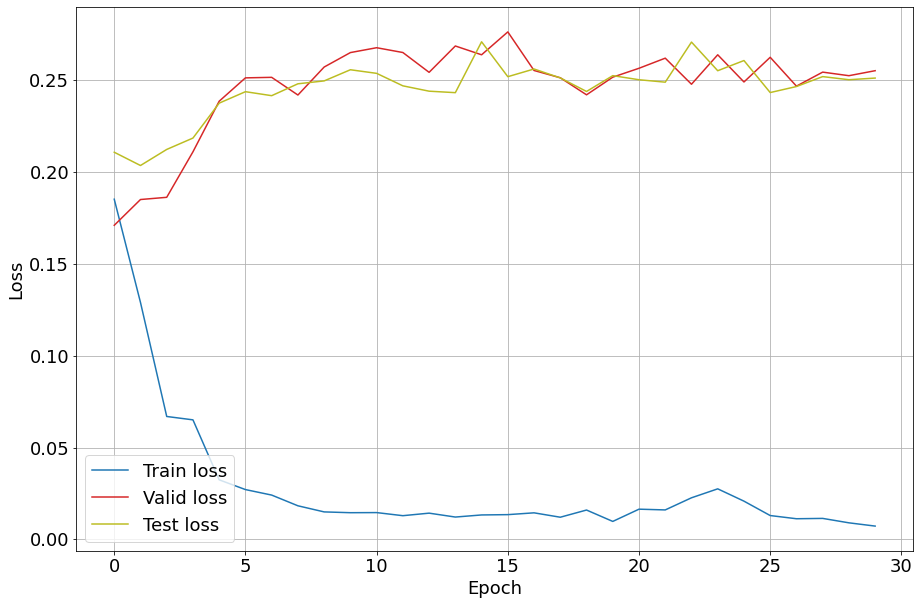

In [11]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss  = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        output[y==0] = y[y==0]
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    # print(f"Train loss: {avg_loss}")
    return avg_loss

def valid_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss  = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            output[y==0] = y[y==0]
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    # print(f"Valid loss: {avg_loss}")
    return avg_loss
    
def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss  = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            output[y==0] = y[y==0]
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    # print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    '''
    CAVEAT: Model is put onto CPU in this function.
    '''
    output = torch.tensor([])
    
    model.cpu()
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

print("Untrained valid loss\n--------")
best_vl = valid_model(valid_loader, model, loss_function)
print(best_vl)
print()

train_loss = []
valid_loss = []
test_loss  = []
for ix_epoch in tqdm(range(PARAMS['n_epochs'])):
    tl = train_model(train_loader, model, loss_function, optimizer=optimizer)
    vl = valid_model(valid_loader, model, loss_function)
    train_loss.append(tl)
    valid_loss.append(vl)
    test_loss.append(test_model(test_loader, model, loss_function))
    if ix_epoch % (PARAMS['n_epochs'] // 4) == 0:
        print(f"Epoch {ix_epoch} / {PARAMS['n_epochs']}\n---------")
        print(f"Train loss: {tl}\nValid loss: {vl}\n")
    # Save model
    if vl < best_vl:
        torch.save(model.state_dict(), PATHS['lstm_path'])

# Plot
plt.plot(train_loss, label='Train loss', color='tab:blue')
plt.plot(valid_loss, label='Valid loss', color='tab:red')
plt.plot(test_loss,  label='Test loss',  color='tab:olive')
plt.xlabel('Epoch');plt.ylabel('Loss')
plt.legend(loc='lower left');plt.grid()

# Load best model
model.load_state_dict(torch.load(PATHS['lstm_path']))

In [ ]:
### METRICS
# Reshape
X_train_lrg = np.reshape(X_train, (-1, X_train.shape[1] * X_train.shape[2]))
y_train_lrg = np.reshape(y_train, (-1, y_train.shape[1] * y_train.shape[2]))
print('X_train regression:', X_train_lrg.shape, '\ny_train regression:', y_train_lrg.shape)
X_test_lrg  = np.reshape(X_test,  (-1, X_test.shape[1]  * X_test.shape[2]))
y_test_lrg  = np.reshape(y_test,  (-1, y_test.shape[1]  * y_test.shape[2]))

# Linear regression
lrg = linear_model.LinearRegression()
lrg.fit(X_train_lrg, y_train_lrg)
print('==> LINEAR \nR2: ', lrg.score(X_test_lrg, y_test_lrg))
print('RMSE Rmax (km):', round(du.rmse(du.inverse_scale_normalize(lrg.predict(X_test_lrg), MU, SIG, SCALE, 'usa_rmw'), du.inverse_scale_normalize(y_test_lrg, MU, SIG, SCALE, 'usa_rmw')), 2))

# # LASSO
# clf = linear_model.Lasso(alpha=1., tol=1)
# clf.fit(X_train_lrg, y_train_lrg)
# print('==> LASSO \nR2: ', lrg.score(X_test_lrg, y_test_lrg))
# print('RMSE Rmax (km):', round(du.rmse(du.inverse_scale_normalize(clf.predict(X_test_lrg), MU, SIG, SCALE, 'usa_rmw'), du.inverse_scale_normalize(y_test_lrg, MU, SIG, SCALE, 'usa_rmw')), 2))

# MODEL
test_dataset_cpu = pu.CompleteTimeseriesDataset(X_test, y_test)
test_loader_cpu  = DataLoader(test_dataset_cpu,  batch_size=PARAMS['batch_size'], shuffle=False)
preds            = predict(test_loader_cpu, model).cpu().detach().numpy()
print('\n==> MODEL')
print('RMSE Rmax (km):', round(du.rmse(du.inverse_scale_normalize(preds, MU, SIG, SCALE, 'usa_rmw'), du.inverse_scale_normalize(y_test_lrg, MU, SIG, SCALE, 'usa_rmw')), 2))

In [ ]:
# X_im[0, 3, :]

In [ ]:
for s in range(6, 9):
    # Choose test sample
    ds_im        = ds_test.isel(storm=slice(s, s + 1))

    # Prepare inference data
    X_im, y_im   = du.get_X_and_y_arrays_from_Dataset(ds_im,  input_variables, target_variable)
    im_dataset   = pu.CompleteTimeseriesDataset(X_im, 
                                                y_im,
                                               )
    im_loader    = DataLoader(im_dataset,  batch_size=PARAMS['batch_size'], shuffle=False)
    # Inference
    y_pred       = predict(im_loader, model)
    # Target
    y_im         = np.array(y_im)

    # Plot
    # feature = .cpu().detach().numpy()
    feature = du.inverse_scale_normalize(y_pred, MU, SIG, SCALE, 'usa_rmw')
    target  = du.inverse_scale_normalize(y_im[0, 0, :],  MU, SIG, SCALE, 'usa_rmw')
    lin_fea = du.inverse_scale_normalize(lrg.predict(np.reshape(X_im, (-1, X_im.shape[1] * X_im.shape[2]))), MU, SIG, SCALE, 'usa_rmw')
    plt.title('usa_rmw', weight='bold')
    plt.plot(target,  label='Data', linewidth=3, color='tab:blue')
    plt.plot(du.inverse_scale_normalize(X_im[0, 3, :], MU, SIG, SCALE, 'usa_r34'), label='R34', color='tab:red', linestyle='--')
    plt.plot(feature[0, :], label='Network', color='tab:pink')
    plt.plot(lin_fea[0, :], label='Regression', color='tab:green', linestyle=':')
    plt.legend(loc='upper left');plt.grid()
    plt.show()